# Example working with airborne imaging spectroscpy data over northern California


data 
## 
        doi:10.5066/F7Q52NZ1



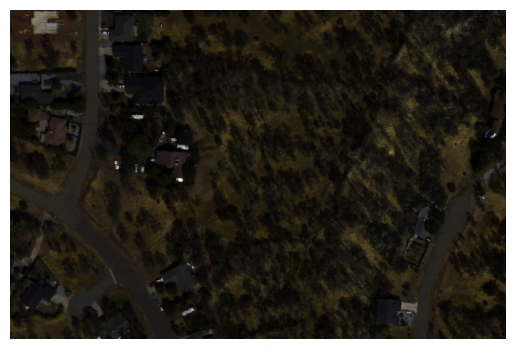

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your hyperspectral raster
raster_path = '../tests/data/ca-test'

# Open the raster file
with rasterio.open(raster_path) as src:
    red = src.read(16)
    green = src.read(13)
    blue = src.read(5)
    array = src.read()

# Normalize the values for display
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

SLIC can be applied on a smaller array using PCA, and can give fairly homogeneous regions that can be used for the HRDSDC method

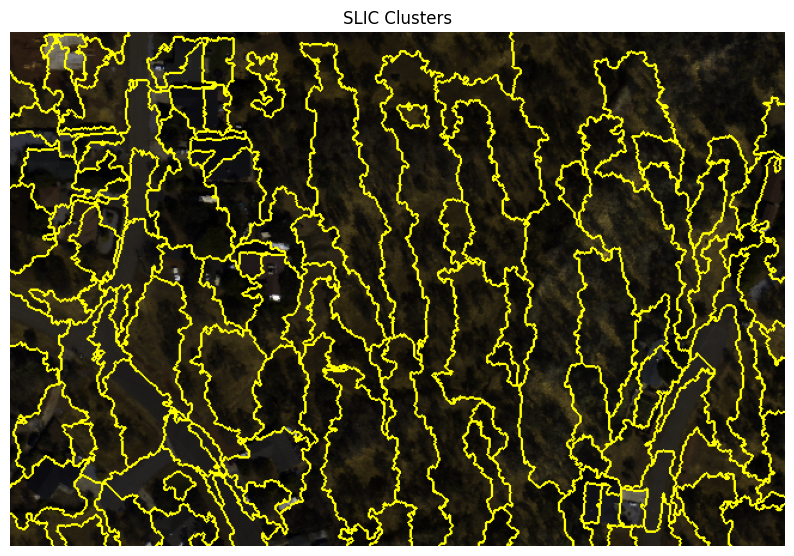

In [2]:
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA

# Open the raster file
with rasterio.open(raster_path) as src:
    array = src.read()

# Rearrange to (rows, cols, bands) for segmentation
array = np.moveaxis(array, 0, -1)

# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
segments = slic(array_pca, 
                n_segments=1000, 
                compactness=0.1)


plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(rgb_image, segments))
plt.title("SLIC Clusters")
plt.axis("off")
plt.show()

This is not a perfect science here, and defining which compactness and n_segments will take iterations and depend on the application.

With these parameters, we can compute the image-wide SNR.

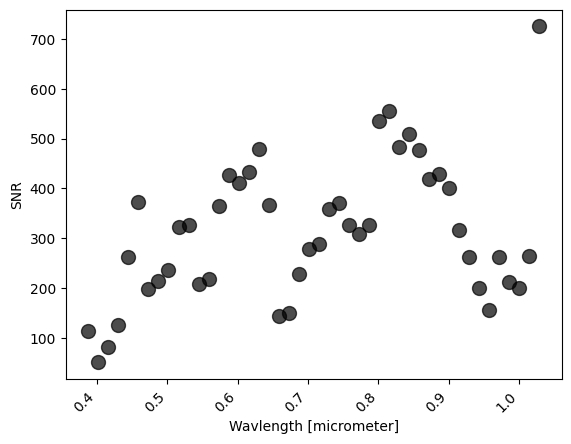

In [7]:
import hysnr

# get wavelengths
wavelengths = hysnr.read_center_wavelengths(raster_path)

# compute HRDSDC
snr = hysnr.hrdsdc(raster_path, n_segments=1000, 
                   compactness=0.1, 
                   n_pca=3, ncpus=3)

plt.scatter(wavelengths, snr, color='black', s=100, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Wavlength [micrometer]')
plt.ylabel('SNR')
plt.show()

Results are comparable to study that used similar method, see: https://doi.org/10.1016/j.rse.2021.112499
